In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

## Network architecture:


**Goal**: the predict the x-y co-ordinates of the top and bottom layer hits from the calorimeter images, the total deposited energy, and the maxEbar energy. 

Since we are dealing with images, the natural choice is to train a CNN. As a first pass, let us train a simple CNN with the images and the energy deposits

Let's load the preprocessed data

In [2]:
unzip_data = np.load("data/preprocessed_scaled_data_v2.npz")
calorimeter_images, calorimeter_data, data_target = unzip_data['arr_0'], unzip_data['arr_1'], unzip_data['arr_2']

In [3]:
N_CHANNELS = 22
N_LAYERS = 14

As a sanity check, let's plot a couple of images

In [ ]:
n_c = 4
n_r = 4
fig, ax = plt.subplots(n_c, n_r, figsize=(14, 14))
for i, ax in enumerate(fig.axes):
    # Here we make a copy so we can manipulate the array without changing it in calorimeter_images
    image = calorimeter_images[i].copy()
    # Filling the zero values with NaNs will show us white space where there is zero deposits recorded.
    # Note that if we didn't have the copy there, this would insert NaNs into calorimeter_images.
    image[image == 0] = 'nan'
    ax.imshow(image, cmap="coolwarm")
    ax.set_xlabel("Readout channel")
    ax.set_ylabel("Layer")
plt.show()

In [ ]:
calorimeter_images.shape

In [ ]:
pixel_density = calorimeter_images[:,:,:,0]

sum_pixels_layer = pixel_density.sum(axis=2)

fig, _ = plt.subplots(5,3, figsize=(40,40))
axes = fig.axes

for i_layer in range(N_LAYERS):
    axes[i_layer].hist(sum_pixels_layer[:,i_layer], bins=np.linspace(0,1,26), histtype='step', linewidth=2)
    axes[i_layer].set_title(f"Layer {i_layer}")
    axes[i_layer].set_xlabel("Sum pixels")
    axes[i_layer].set_ylabel("Counts")
    axes[i_layer].semilogy()

plt.show()
fig.clf()

In [ ]:
sum_pixels_layer.shape

## Split the data into training and testing datasets

In [4]:
from sklearn.model_selection import train_test_split

In [5]:
train_images, testing_images, train_energies, testing_energies, train_coords, testing_coords \
= train_test_split(calorimeter_images, calorimeter_data, data_target, train_size=0.3, shuffle=True)

In [6]:
test_images, trial_images, test_energies, trial_energies, test_coords, trial_coords \
= train_test_split(testing_images, testing_energies, testing_coords, test_size=0.2, shuffle=True)

## Set up a network

First, let us set up a CNN with just the images

In [7]:
from tensorflow.keras.layers import Conv2D, GlobalAveragePooling2D, GlobalMaxPooling2D, Concatenate, MaxPool2D
from tensorflow.keras.layers import Input, Dense, Flatten
from tensorflow.keras.models import Model

In [8]:
in_images = Input(shape=(N_LAYERS, N_CHANNELS, 1))
in_energies = Input(shape=(2,))

h = Conv2D(filters=32,
            kernel_size=(3,3),
            strides=(1,1),
            padding='same',
            data_format="channels_last",
            use_bias=True,
            activation="relu")(in_images)

h = Conv2D(filters=32,
            kernel_size=(3,3),
            strides=(1,1),
            padding='same',
            data_format="channels_last",
            use_bias=True,
            activation='relu')(h)

h = Conv2D(filters=64,
            kernel_size=(3,3),
            strides=(1,1),
            padding='same',
            data_format="channels_last",
            use_bias=True,           
            activation='relu')(h)

h = GlobalMaxPooling2D()(h)

h = Concatenate(axis=-1)([h, in_energies])

h = Flatten()(h)

h = Dense(units=128, activation='relu', use_bias=True)(h)

# h = Dense(units=, activation='relu', use_bias=True)(h)

outputs = Dense(units=4, activation='linear')(h)

model = Model(inputs=[in_images, in_energies], outputs=outputs)

2022-05-17 07:08:51.132032: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [9]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 14, 22, 1)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 14, 22, 32)   320         ['input_1[0][0]']                
                                                                                                  
 conv2d_1 (Conv2D)              (None, 14, 22, 32)   9248        ['conv2d[0][0]']                 
                                                                                                  
 conv2d_2 (Conv2D)              (None, 14, 22, 64)   18496       ['conv2d_1[0][0]']               
                                                                                              

In [10]:
batchsize = 128
learning_rate = 0.01
num_epochs = 100
verbosity = 0

In [11]:
optimizer = tf.keras.optimizers.Adagrad(learning_rate=learning_rate)

In [12]:
model.compile(optimizer=optimizer, loss='mse', metrics=[tf.keras.metrics.MeanSquaredError()])

In [13]:
history = model.fit([train_images,train_energies], train_coords, 
                    epochs=num_epochs, verbose=verbosity,
                    batch_size=batchsize, validation_data=([test_images,test_energies], test_coords),
                    callbacks=tf.keras.callbacks.EarlyStopping(monitor="val_loss",
                                                               patience=5,
                                                               restore_best_weights=True))

## Preliminary cross checks

In [14]:
import plotting

In [15]:
plotting.make_pretty_format()

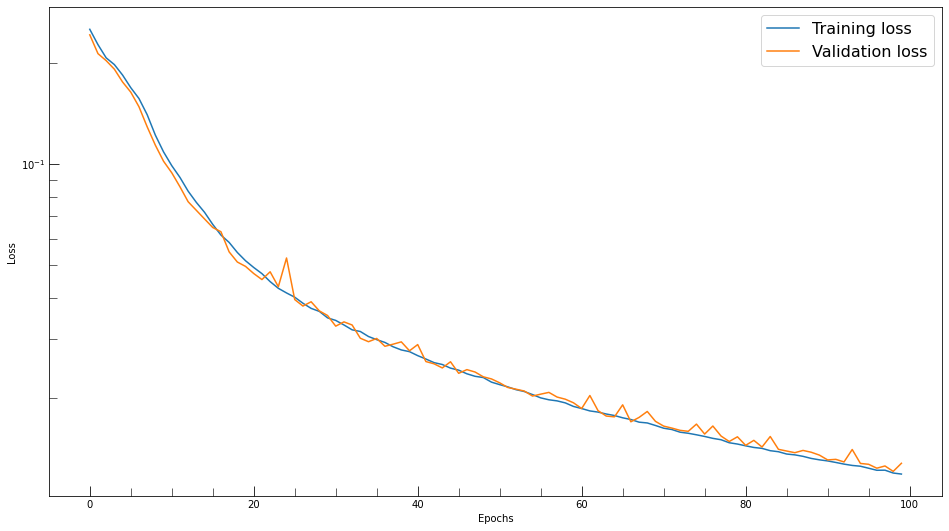

In [17]:
fig = plotting.plot_losses(history)

plt.minorticks_on()
plt.semilogy()

plt.show()
fig.clf()

### Predict the x-y co-ordinates for the test data

In [18]:
pred_coords = model.predict([trial_images,trial_energies], batch_size=500)

### Plot the predicted-truth linearity

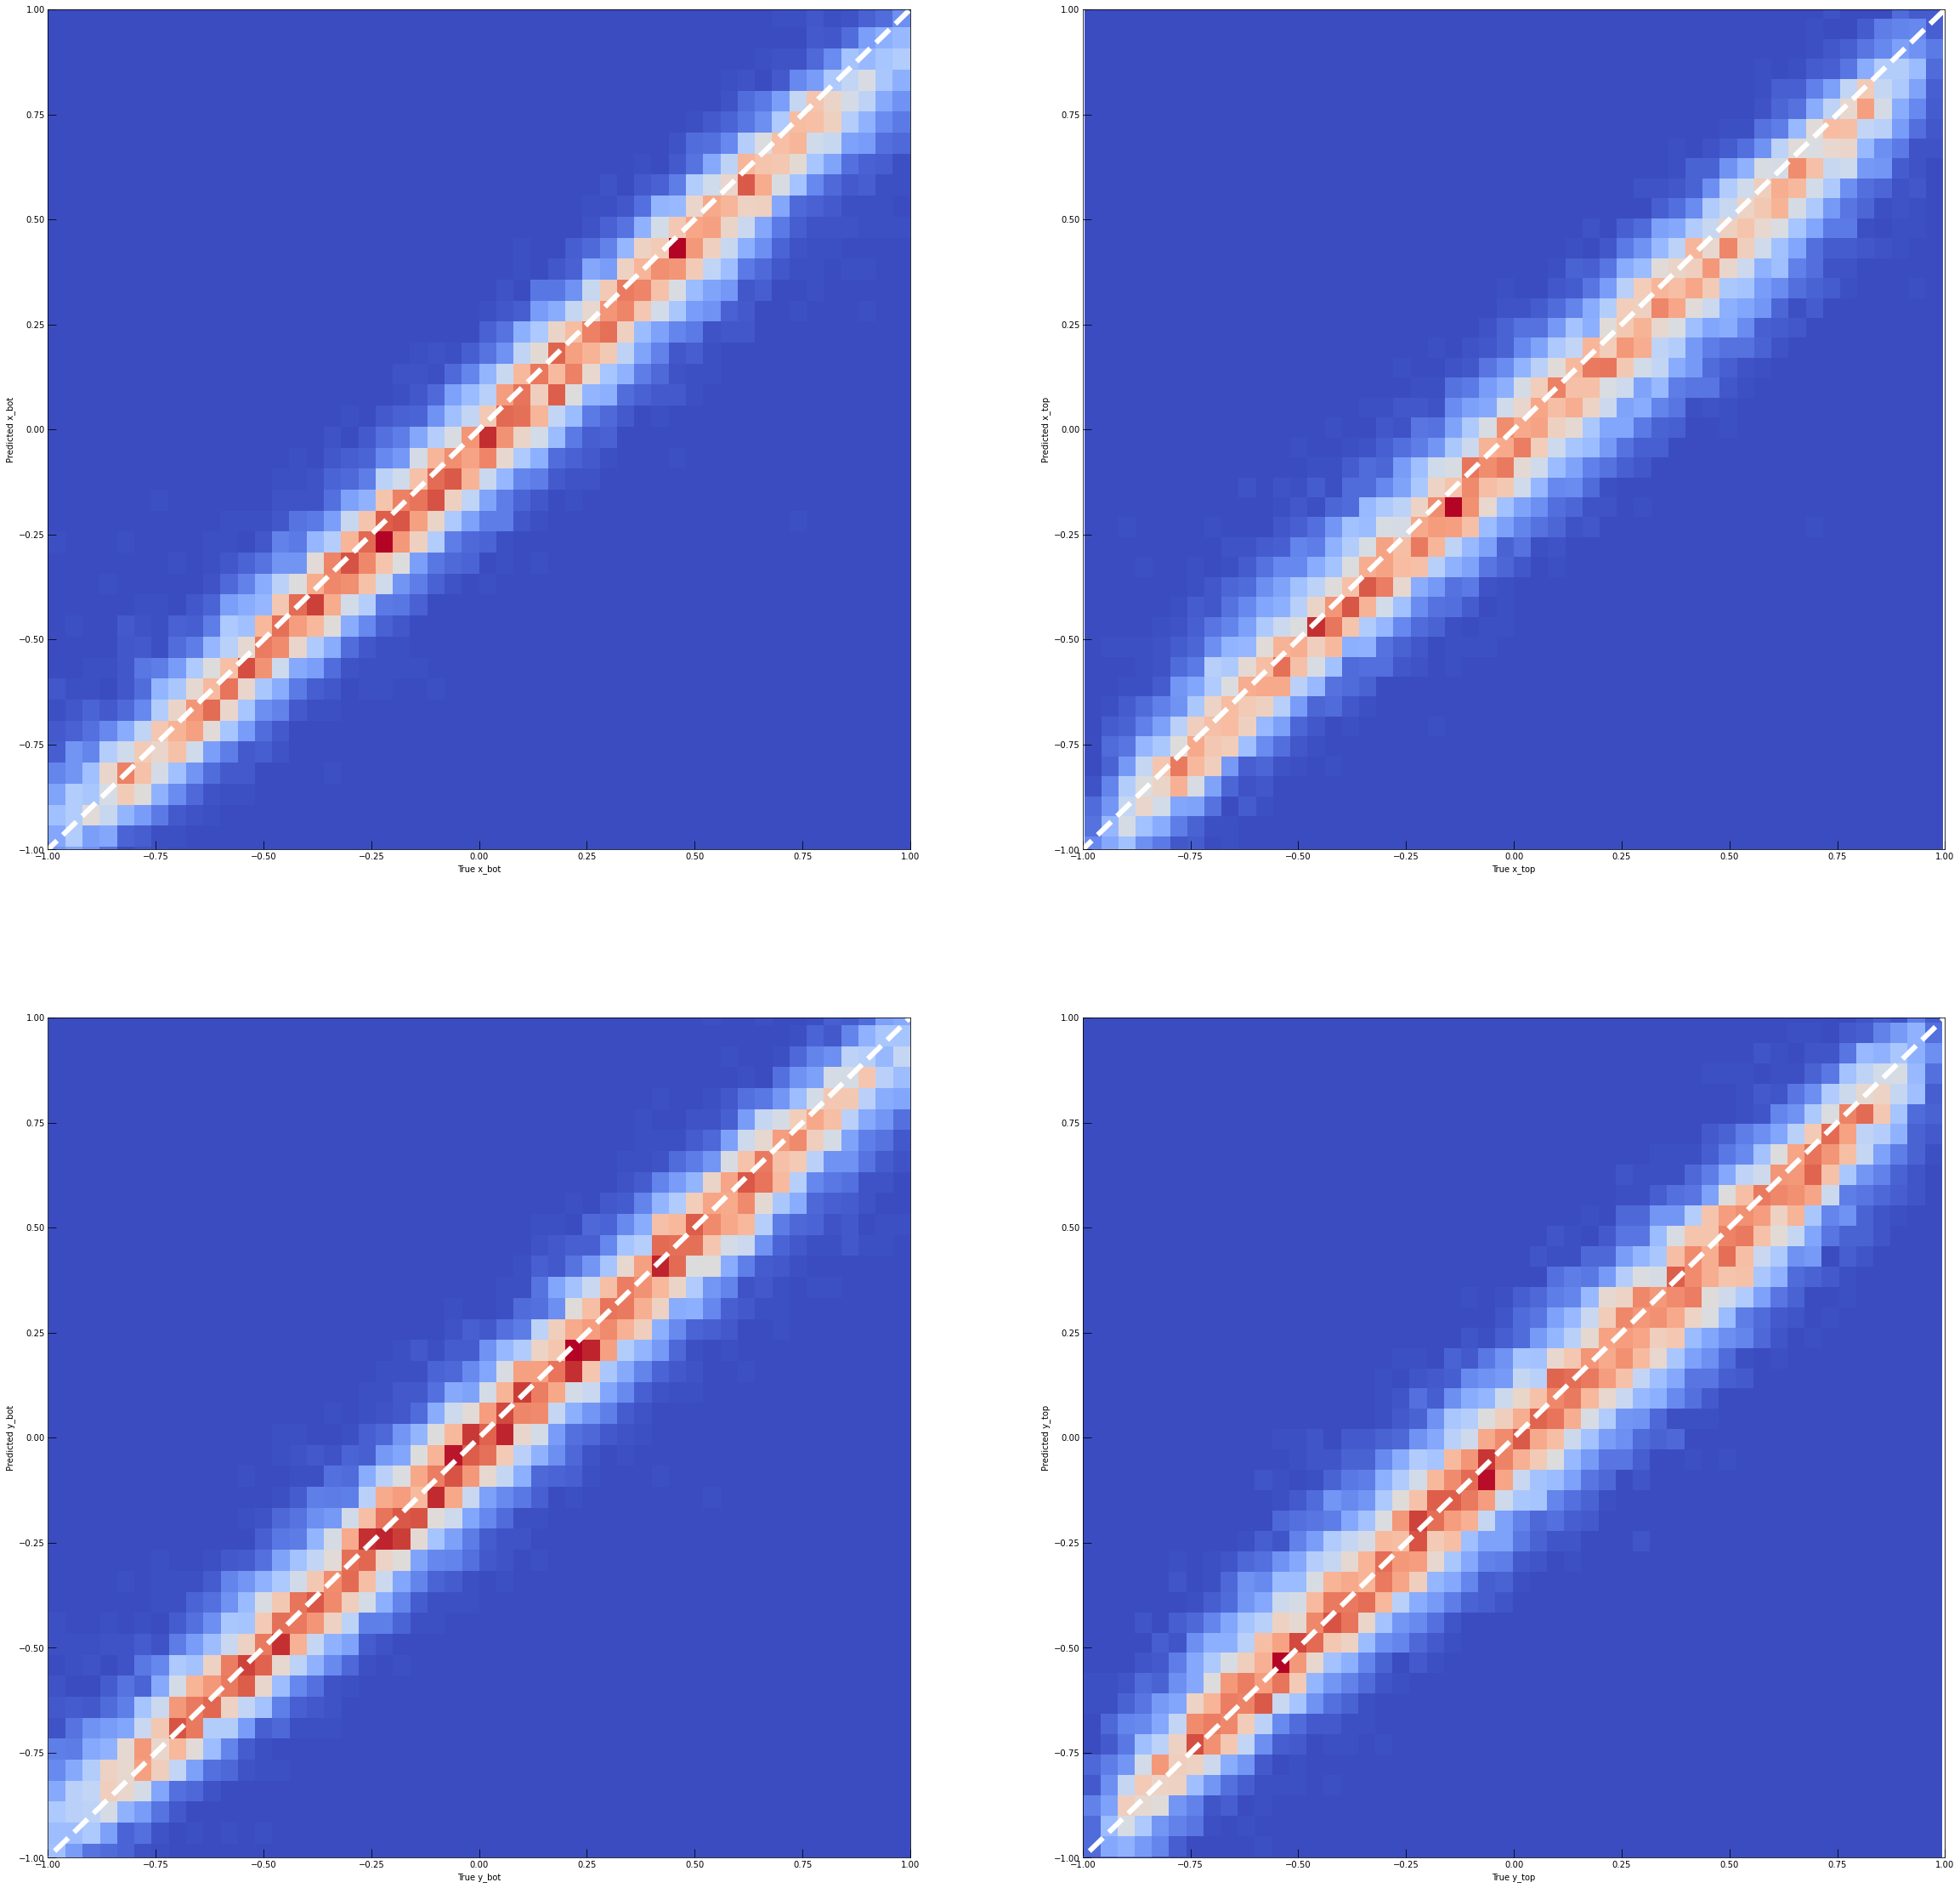

In [29]:
labels = ['x_bot', 'x_top', 'y_bot', 'y_top']

fig = plotting.plot_predictions(pred_coords, trial_coords, var_label=labels)

plt.show()
fig.clf()

### Plot the predicted - truth bias

/code/dpanchal/UniGe/final-project-dampe/plotting.py:19: RuntimeWarning: invalid value encountered in sqrt
  return (A / np.sqrt(sigma)) * np.exp(-1.0 * (x - mu)**2 / (2 * sigma**2))


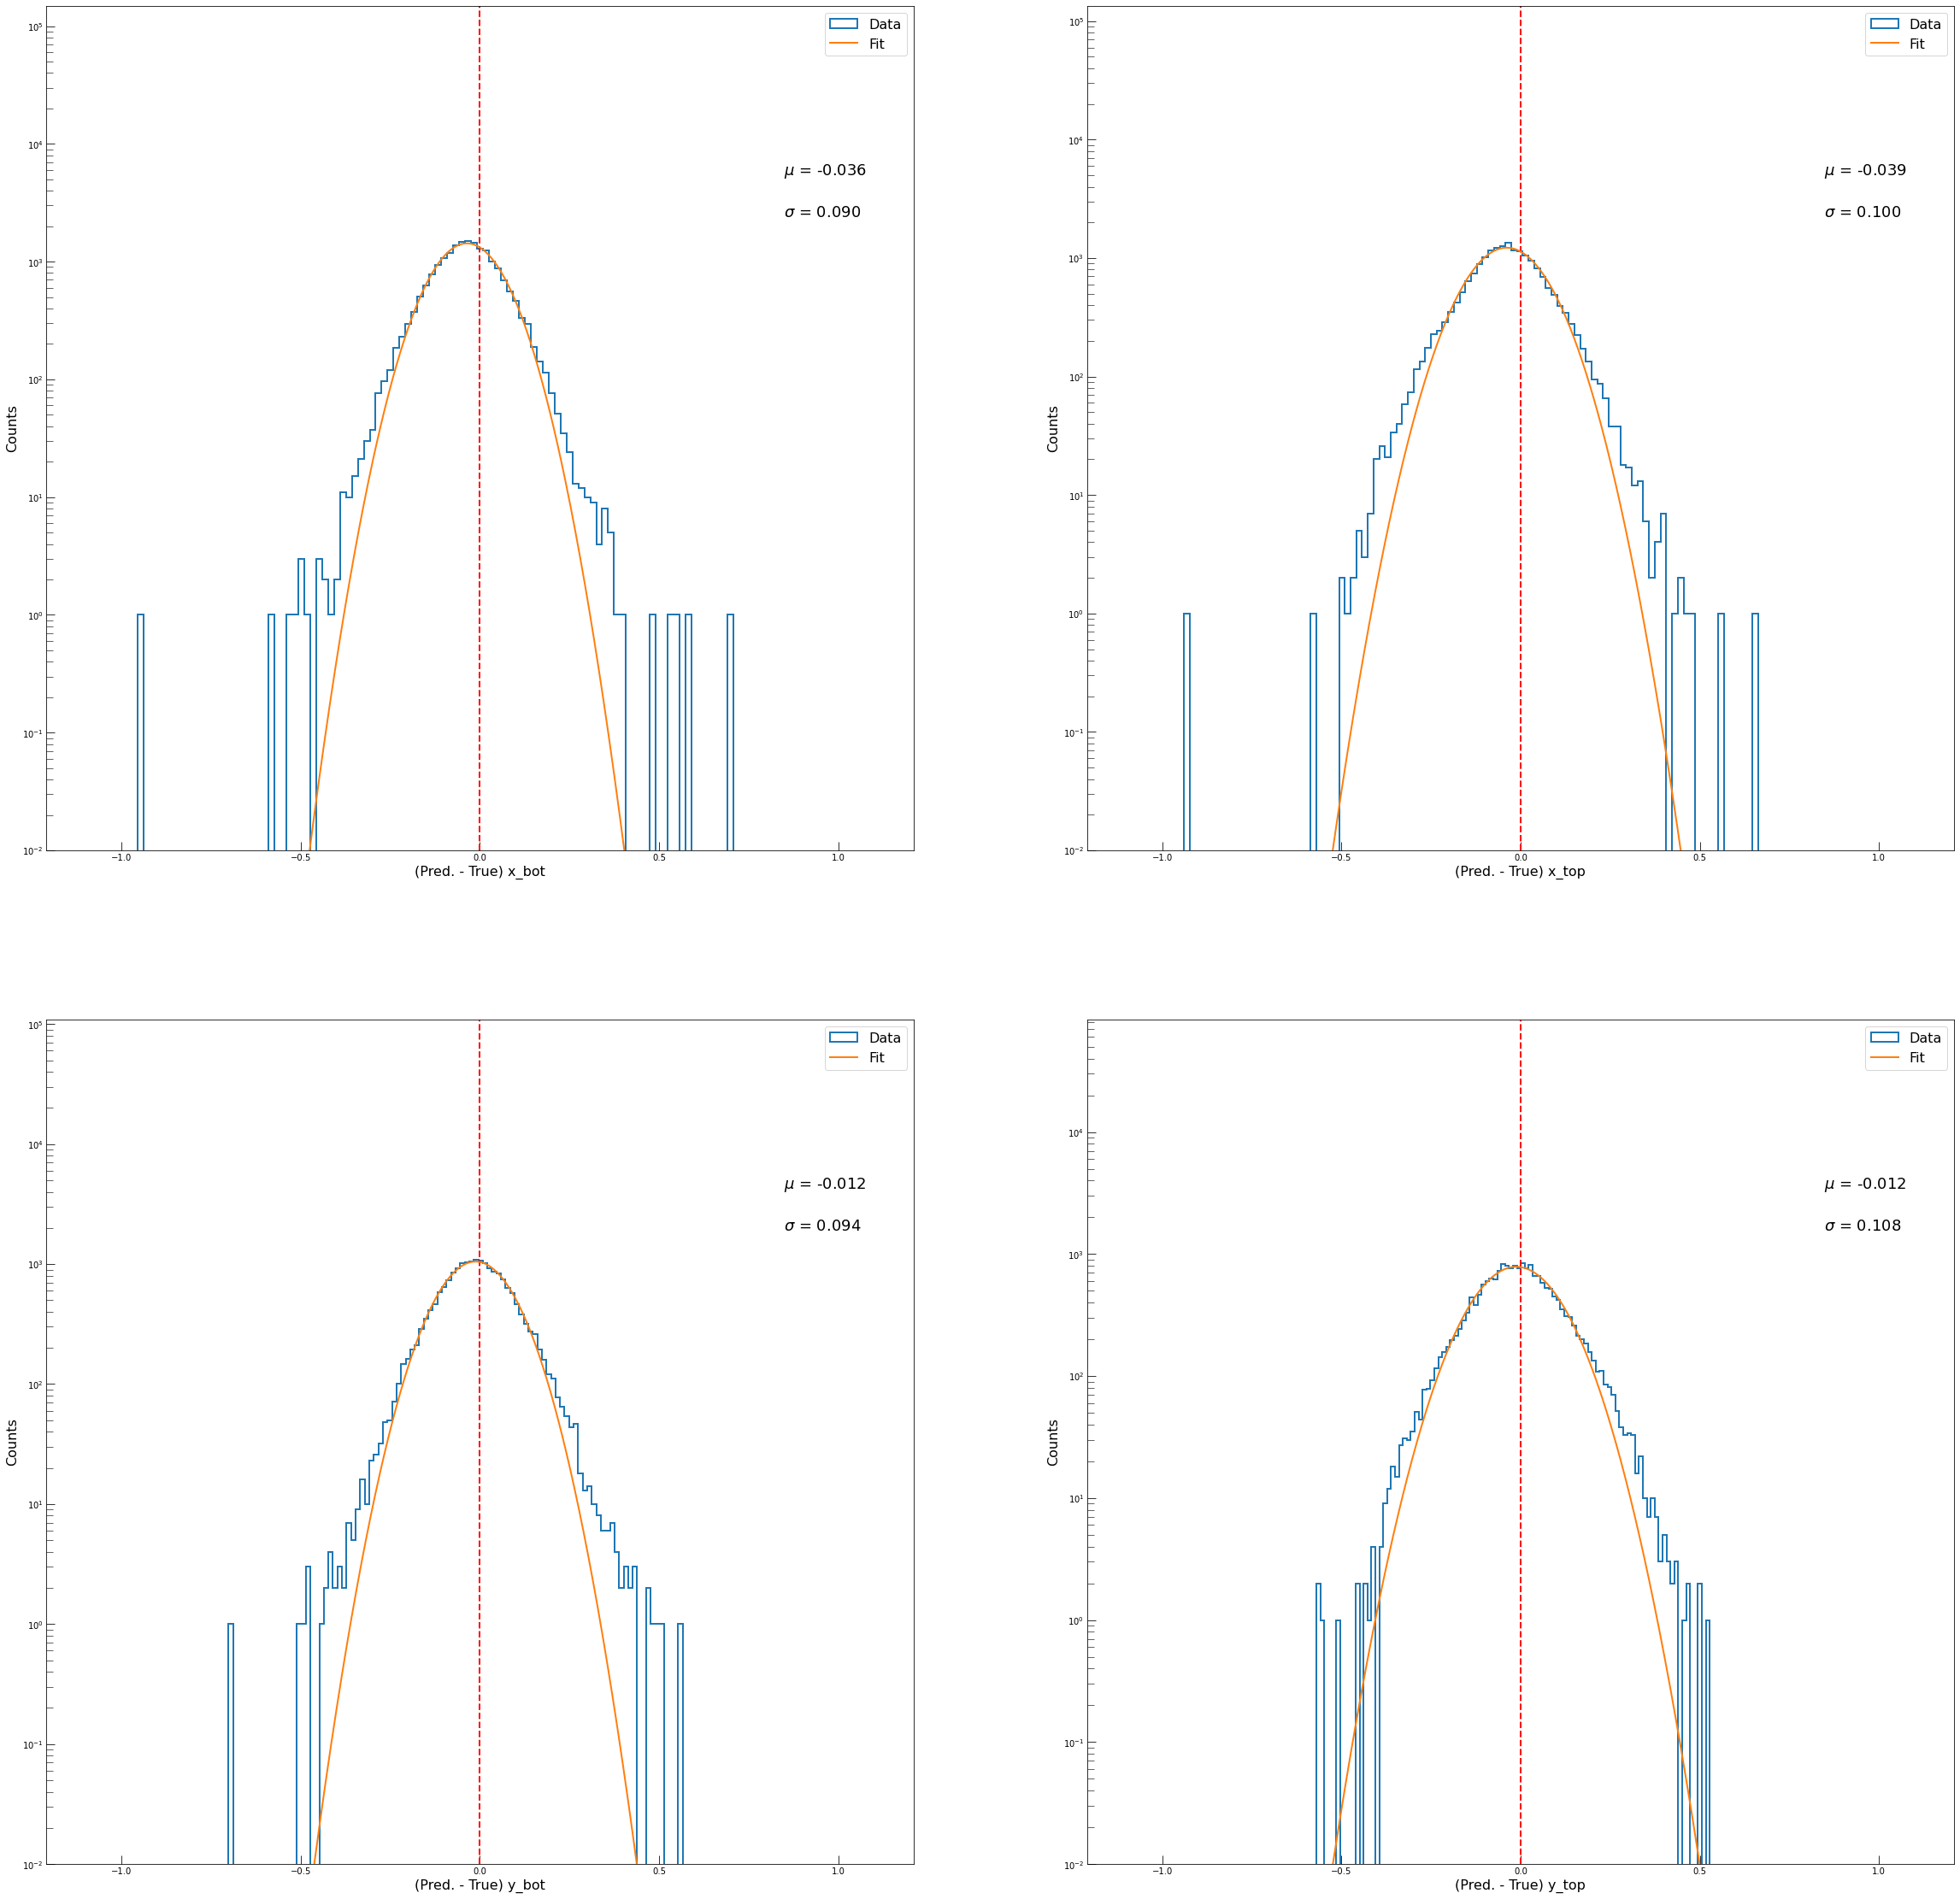

In [27]:
fig = plotting.plot_bias(pred_coords, trial_coords, var_label=labels, fit_bias=True)

plt.show()
fig.clf()

### Plot the bias vs. truth 

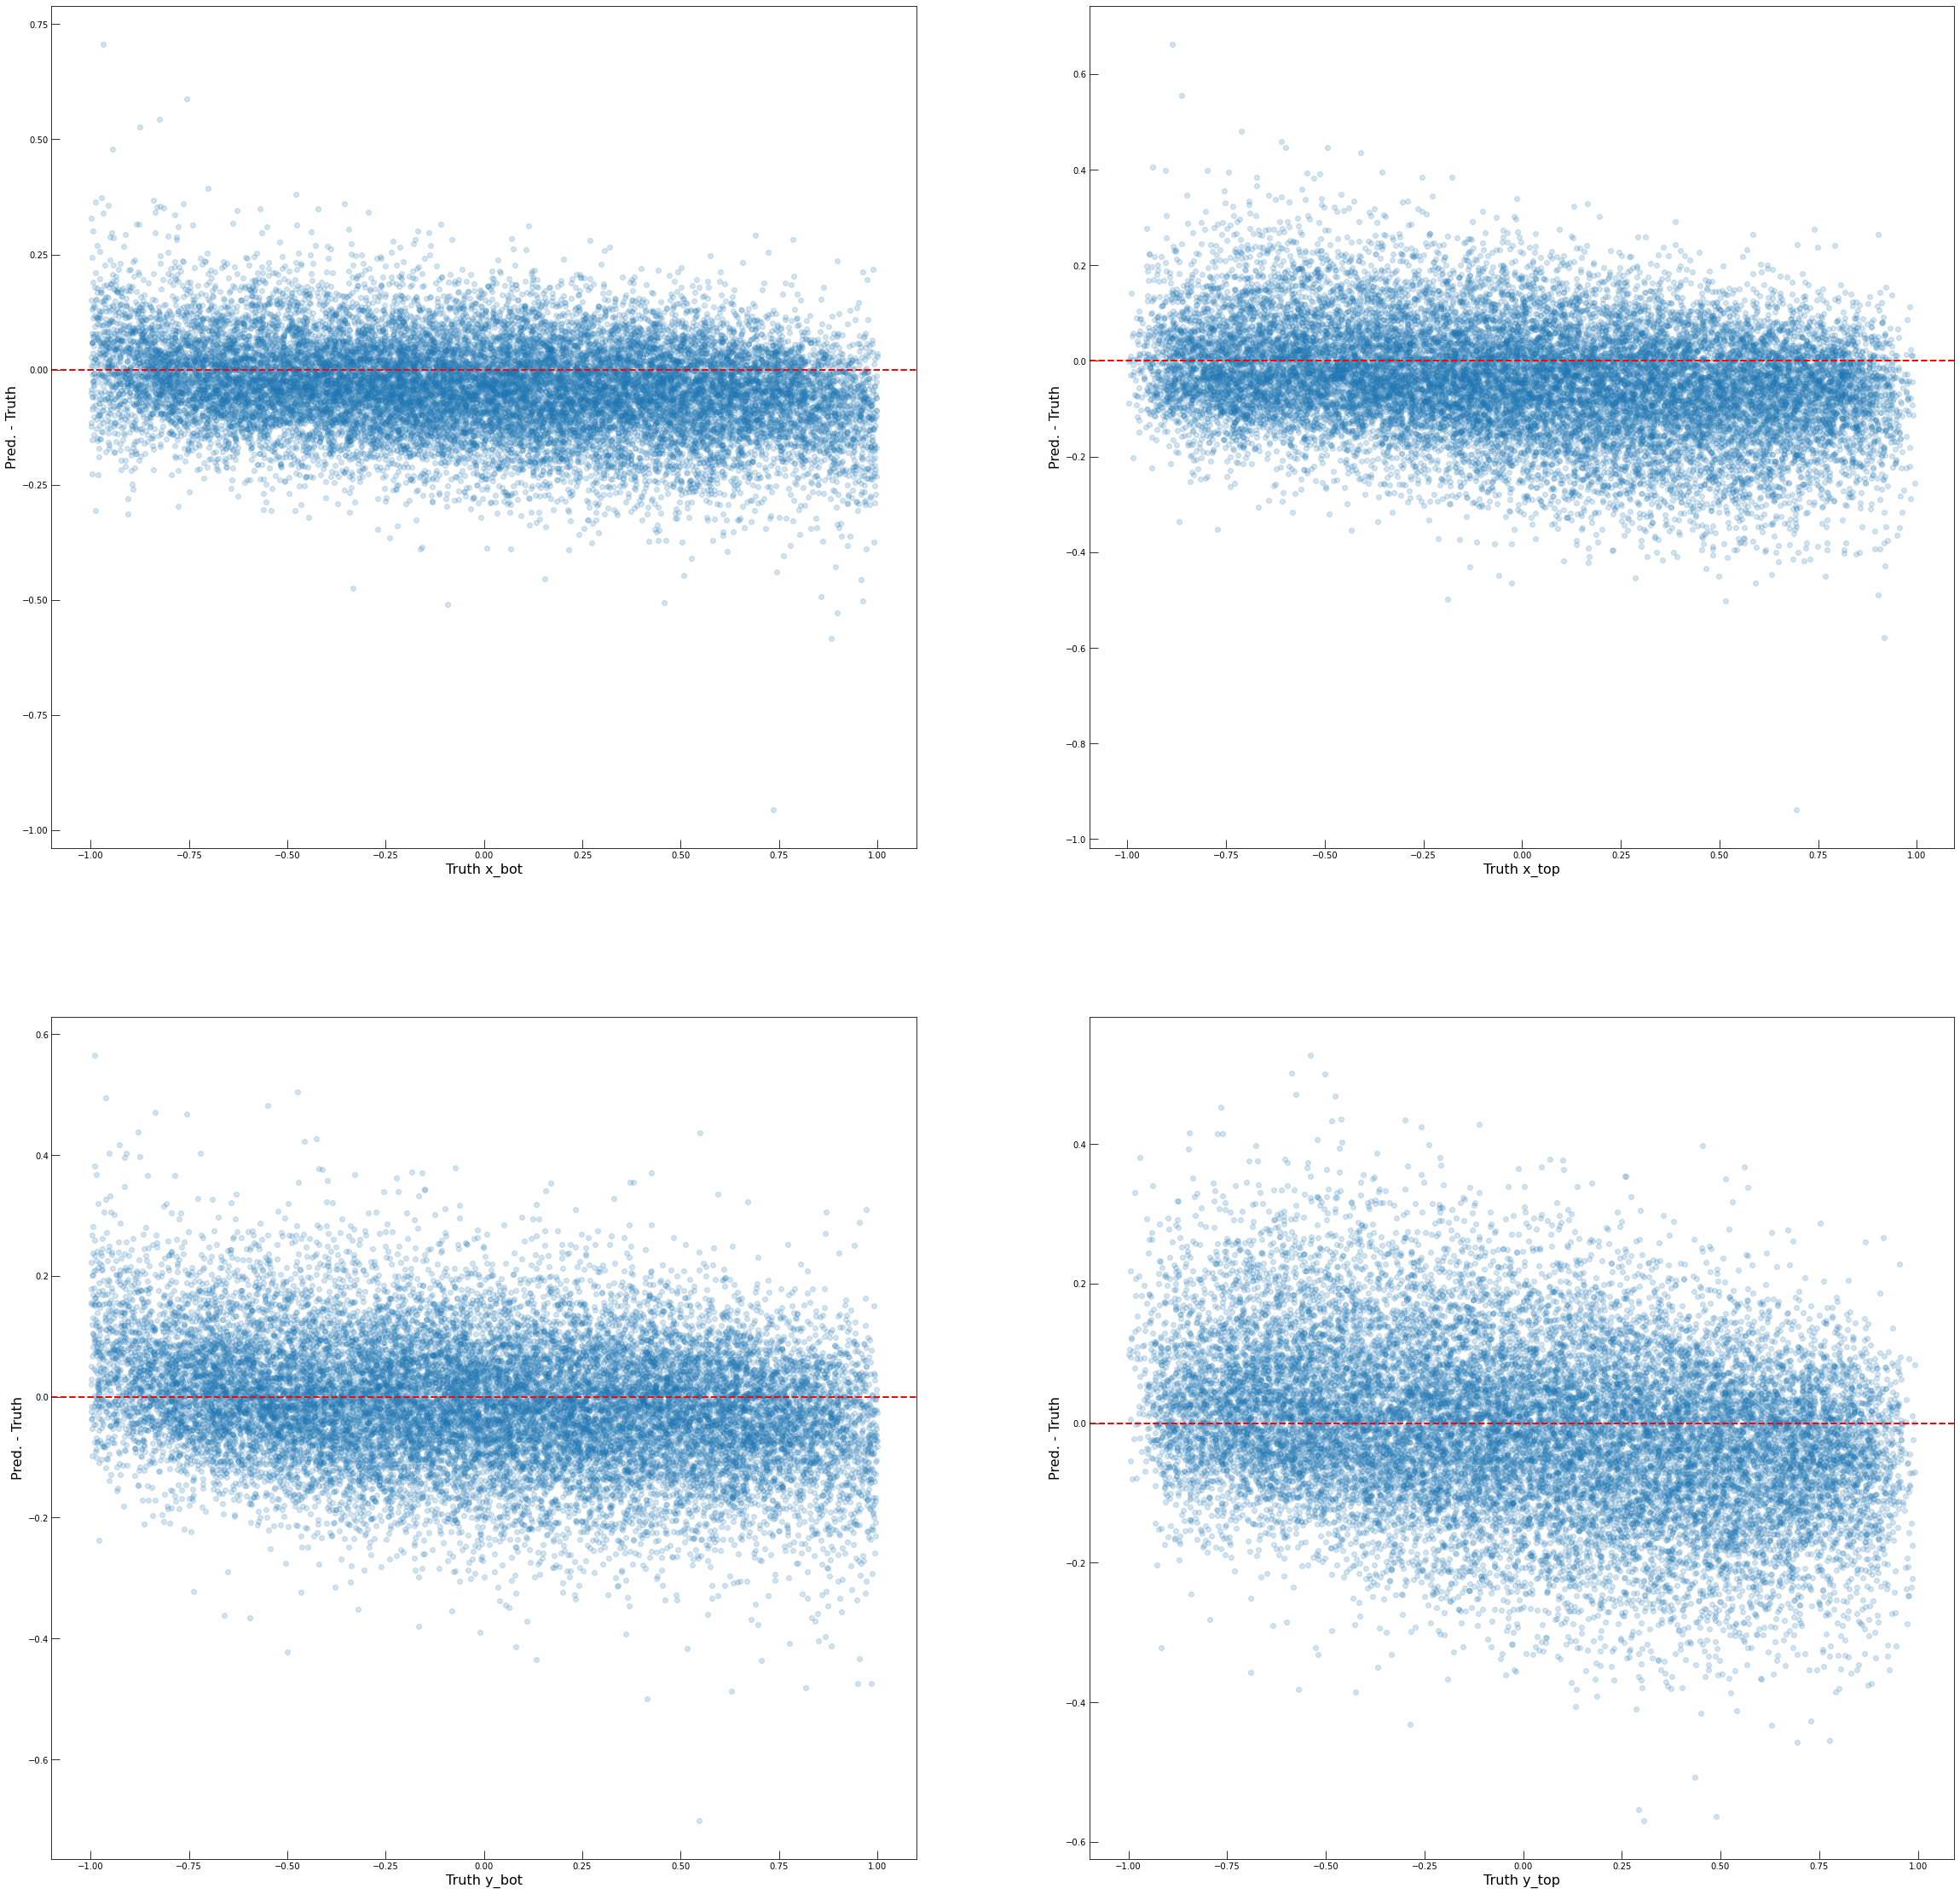

In [28]:
fig = plotting.plot_bias_truth(pred_coords, trial_coords, var_label=labels)

plt.show()
fig.clf()

### Plot the co-ordinates as a 2D histogram

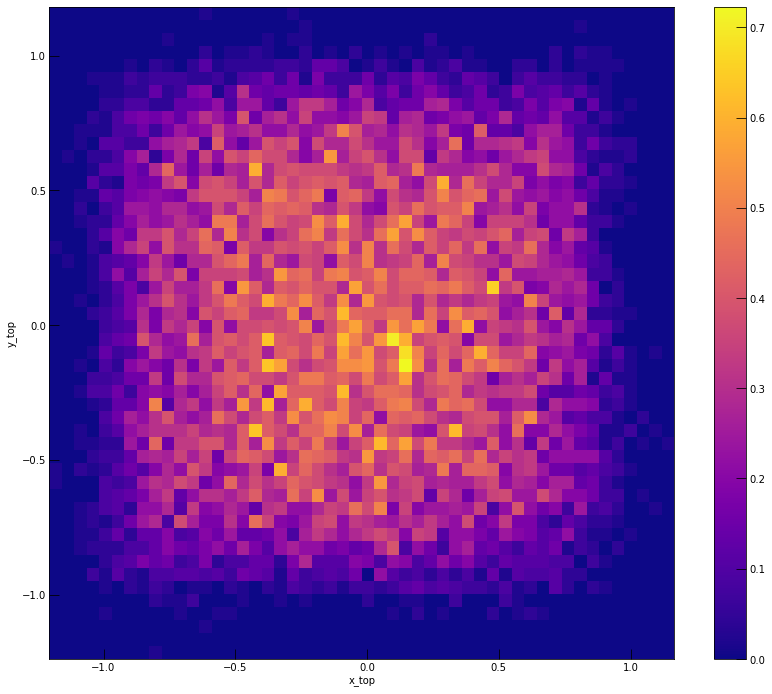

In [30]:
fix, ax = plt.subplots(figsize=(14,12))

h = ax.hist2d(pred_coords[:, 1], pred_coords[:, 3], 
              bins=50, cmap='plasma', 
              density=True, 
              cmin=0.0, cmax=1.0)
ax.set_xlabel('x_top')
ax.set_ylabel('y_top')
fig.colorbar(h[3], ax=ax)
plt.show()

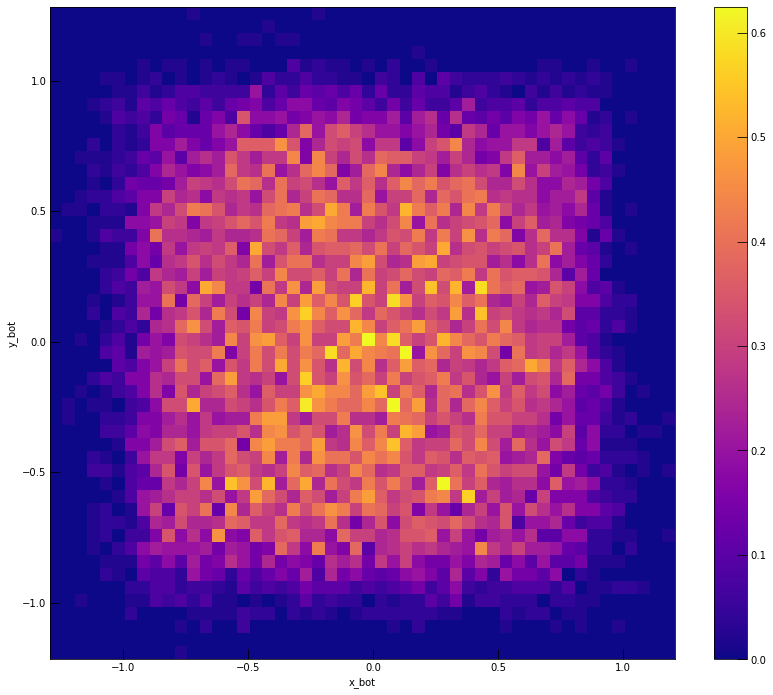

In [31]:
fix, ax = plt.subplots(figsize=(14,12))

h = ax.hist2d(pred_coords[:, 0], pred_coords[:, 2], 
              bins=50, cmap='plasma', 
              density=True,
              cmin=0.0, cmax=1.0)
ax.set_xlabel('x_bot')
ax.set_ylabel('y_bot')
fig.colorbar(h[3], ax=ax)
plt.show()

## Save model

In [ ]:
# model.save("cnn_2022_05_17")